# Model validation Mich

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Functions

In [2]:
# Modify the OS status to match the common convention
modifyOSStatus = function(x){
    status = unlist(strsplit(x, split = ":"))[1]
    return(status)
}

# Add patient id from sample clin data
addPatientId = function(exp.data, sample.clin.data){
    sample.clin.data.minimal = sample.clin.data %>% dplyr::select(PATIENT_ID, SAMPLE_ID)
    sample.clin.data.minimal$Sample = sample.clin.data.minimal$SAMPLE_ID
    sample.clin.data.minimal = sample.clin.data.minimal %>% dplyr::select(-SAMPLE_ID)
    exp.data =  dplyr::left_join(exp.data, 
                                 sample.clin.data.minimal, by = "Sample")
    return(exp.data)
}

# Add survival data from patient clin data 
addSurvivalData = function(exp.data, patient.clin.data){
    patient.clin.data.minimal = patient.clin.data %>% dplyr::select(PATIENT_ID, OS, OS.time)
    exp.data =  dplyr::left_join(exp.data, 
                                 patient.clin.data.minimal, by = "PATIENT_ID")

}

# 
# Function fits a cox regression model
# 
fitCoxModel = function(data, end.point, features){
    
    end_point_event = end.point
    end_point_time = paste0(end.point, ".time")
    
    # Generate a survival formula object 
    survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
    f <- as.formula(paste(survExpression, paste(features, collapse = " + "), sep = " ~ "))
    
    model.fit = coxph(f, data = data)
    return(model.fit)
}

#
# Plot Kaplan-Meier curve by relative risk
#
plotKMbyRelativeRisk = function(data, rel.risk) {

    # Assign relative risk 
    data$pred <- rel.risk
    data$group <- ifelse(data$pred  < median(data$pred), "Low", "High")

    if (length(table(data$group)) == 2) {

        # Fit the survival function 
        s.fit.train <- survfit(Surv(time, status) ~group, data = data)

        # Generate the formula for the model 
        survExpression = paste0("Surv(", "time", ", " , "status", ")")
        f <- as.formula(paste(survExpression, "group", sep = " ~ "))
        sFit <- surv_fit(f, data =  data)

        # Initialise results object 
        sFit.res = list()

        # Prepare plot  
        sFit.res$Plot <- ggsurvplot(s.fit.train, 
                           data = data, legend = "bottom",
                           title = paste0("Risk groups", " (n = ", nrow(data) ,")"),
                           legend.title = "Risk group", pval = TRUE, xlab = "Time (days)", 
                          font.family = "Helvetica", font.x = 15, font.y = 15, font.tickslab = 15, font.legend = 15,
                           conf.int = T,
                           break.time.by = 10,
                           surv.plot.height = 0.65, risk.table = TRUE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 7, tables.font.tickslab = 5, tables.y.text.col = T, tables.y.text = FALSE, 
                           tables.theme = theme_survminer())
   

        # Store relevant information as table 
        sFit.res$table = data.frame(N = nrow(data), 
                                Pvalue = surv_pvalue(sFit))

    } else {
        # Based on the predicted risk it was impossible to group into two groups
        # we cannot get a p-value 
        sFit.res = NULL
    } 
    return(sFit.res)
}

## Load and preprocess data

In [3]:
data.dir = "/workstation//project_data/landstrom_project_3/prad_mich/"

### Clinical patient data

In [4]:
# Clinical data for patients 
clinical.patients = read.csv(file.path(data.dir, "data_clinical_patient.csv"), sep = "\t")

# Remove all patients without OS_STATUS
clinical.patients = clinical.patients[clinical.patients$OS_STATUS != "",]

# Modify the OS_Status
clinical.patients$OS = as.numeric(unlist(map(clinical.patients$OS_STATUS, modifyOSStatus)))
clinical.patients$OS.time =  clinical.patients$OS_MONTHS

# Remove patients without overal survival time
clinical.patients = clinical.patients[!is.na(clinical.patients$OS.time),]

### Clinical sample data

In [5]:
# Clinical data for patients 
clinical.samples = read.csv(file.path(data.dir, "data_clinical_sample.csv"), sep = "\t")

# Select only samples from patients with OS status
clinical.samples = dplyr::filter(clinical.samples, PATIENT_ID %in% clinical.patients$PATIENT_ID)

In [6]:
sample.counts.per.patient = as.data.frame(table(clinical.samples$PATIENT_ID))

In [7]:
colnames(sample.counts.per.patient) = c("PATIENT_ID", "FREQ")
sample.counts.per.patient = arrange(sample.counts.per.patient, desc(FREQ))

Keep track of the patients with multiple samples. We need to deal with this somehow later.

In [8]:
patients.with.multi = sample.counts.per.patient$PATIENT_ID[sample.counts.per.patient$FREQ > 1]

In [9]:
patients.with.multi

[1] WA43
48 Levels: WA10 WA11 WA12 WA13 WA14 WA15 WA16 WA17 WA18 WA19 WA20 WA22 ... WA7

### Expression data

In [10]:
# Capture data 
expression.data.rpkm = read.csv(file.path(data.dir, "data_mrna_seq_rpkm_zscores_ref_diploid_samples.csv"), 
                                   sep = "\t", check.names = F)

In [11]:
# Select samples included in the clinical.samples 
expression.data.rpkm = expression.data.rpkm[,colnames(expression.data.rpkm) %in% c("Hugo_Symbol", clinical.samples$SAMPLE_ID)]

In [12]:
dim(expression.data.rpkm)

[1] 20709    32

## Merge the expression data and clinical data 

First transpose the expression tables

In [13]:
expression.data.rpkm.long = expression.data.rpkm %>% pivot_longer(-Hugo_Symbol, 
                                 values_to = "Expression", 
                                 names_to = "Sample")

expression.data.rpkm.wider = expression.data.rpkm.long %>% 
                               pivot_wider(names_from = Hugo_Symbol,
                                           values_from =  Expression,
                                           values_fn = ~mean(.x, na.rm = TRUE))  

colnames(expression.data.rpkm.wider)[2:ncol(expression.data.rpkm.wider)] = paste0(colnames(expression.data.rpkm.wider)[2:ncol(expression.data.rpkm.wider)], ".exp")


In [14]:
# Add patient ids for samples 
expression.data.rpkm.with.patid = addPatientId(expression.data.rpkm.wider, clinical.samples)

In [15]:
# Add survival data from patient clin data
expression.data.rpkm.final = addSurvivalData(expression.data.rpkm.with.patid, clinical.patients)

In [16]:
table(expression.data.rpkm.final$PATIENT_ID)


WA10 WA11 WA13 WA14 WA16 WA18 WA19 WA20 WA22 WA23 WA24 WA25 WA26 WA28 WA29  WA3 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
WA30 WA31 WA32 WA33 WA35 WA37 WA39 WA40 WA42 WA46 WA47 WA53 WA54 WA55  WA7 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 

No duplicate ids

## Fit the Cox-model including the model genes

In [17]:
library(survival)
library(survminer)
library(ggplot2)
library(survcomp)

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: prodlim



Output directory :

In [18]:
out.dir = "/workstation/project_results/landstrom_project_3/manuscript_work/PRAD_validation_OS/MICH/"

Genes included in the final PFI model were AURKA, AURKB, KIF23 and PTEN

In [19]:
# Final variable selection
expression.data.rpkm.final = expression.data.rpkm.final %>% 
       dplyr::select(OS, OS.time, AURKA.exp, AURKB.exp, KIF23.exp, PTEN.exp)

Fitting the model

In [20]:
cox.model = fitCoxModel(expression.data.rpkm.final, 
            end.point = "OS", 
            features = c("AURKA.exp", "AURKB.exp", "KIF23.exp", "PTEN.exp"))

In [21]:
cox.model

Call:
coxph(formula = f, data = data)

              coef exp(coef) se(coef)      z     p
AURKA.exp  0.29810   1.34729  0.45026  0.662 0.508
AURKB.exp  0.07499   1.07788  0.62378  0.120 0.904
KIF23.exp -0.35049   0.70435  0.40676 -0.862 0.389
PTEN.exp   0.16833   1.18332  0.19262  0.874 0.382

Likelihood ratio test=2.11  on 4 df, p=0.7156
n= 31, number of events= 31 

Calculate C-index 

In [22]:
rel.risk = predict(object = cox.model)

In [23]:
# Prepare data
y.data = expression.data.rpkm.final %>% dplyr::select(OS, OS.time)
colnames(y.data) = c("status","time")

In [24]:
cindex = concordance.index(rel.risk, 
                                     y.data$time, 
                                     y.data$status,
                                     na.rm = TRUE)

In [25]:
# Collect the results 
c.index.results = data.frame("dataset" = c("mich"), 
           "C.index" = cindex$c.index,
           "CI" = paste0(round(cindex$lower,3),"-",round(cindex$upper),3))

In [26]:
c.index.results 

dataset,C.index,CI
<chr>,<dbl>,<chr>
mich,0.5686275,0.333-13


Prepare KM-plot

In [27]:
# Plot KM
km.res = plotKMbyRelativeRisk(data = y.data, 
                                     rel.risk = rel.risk)

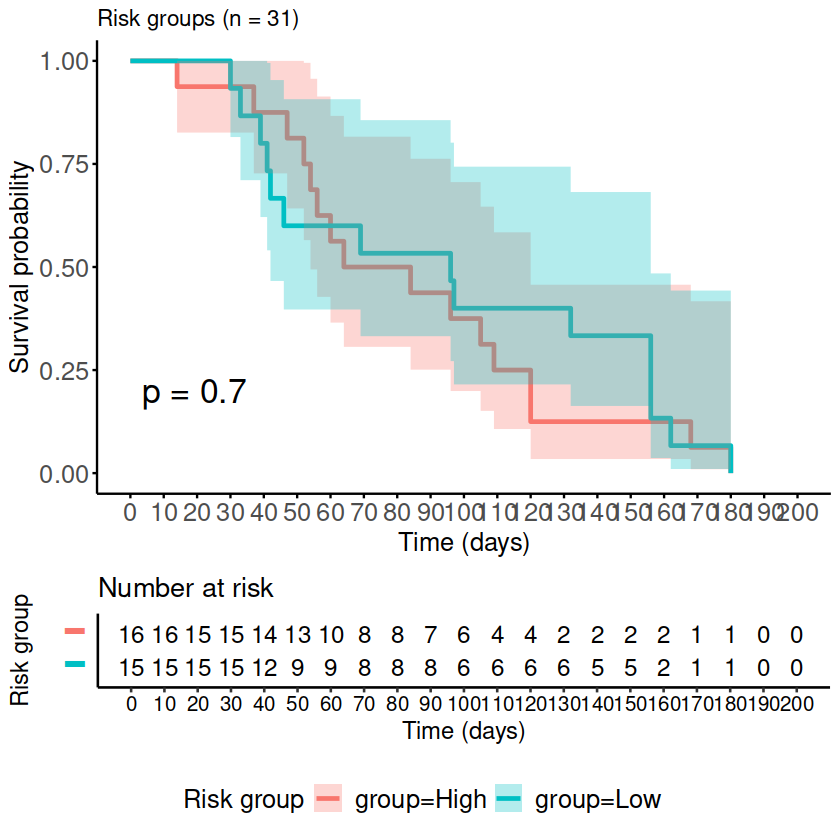

In [28]:
km.res$Plot

In [30]:
ggsave(km.res$Plot$plot, filename = file.path(out.dir, "KM_OS_MICH_samples.pdf"))

Saving 6.67 x 6.67 in image

